Loading ESOL dataset from CSV file...
Total number of compounds: 1128
Feature columns:
- Molecular Weight: 16.043 to 780.9490000000001
- Number of H-Bond Donors: 0 to 11
- Number of Rings: 0 to 8
- Number of Rotatable Bonds: 0 to 23
- Polar Surface Area: 0.0 to 268.67999999999995
- Minimum Degree: 0 to 2
Train set: (902, 7), Validation set: (226, 7)
Target variable: measured log solubility in mols per litre

Feature correlations with target (solubility):
                     feature  correlation
0           Molecular Weight    -0.640189
2            Number of Rings    -0.512279
3  Number of Rotatable Bonds    -0.244256
1    Number of H-Bond Donors     0.209429
5             Minimum Degree    -0.130445
4         Polar Surface Area     0.123210
6                     random     0.045824


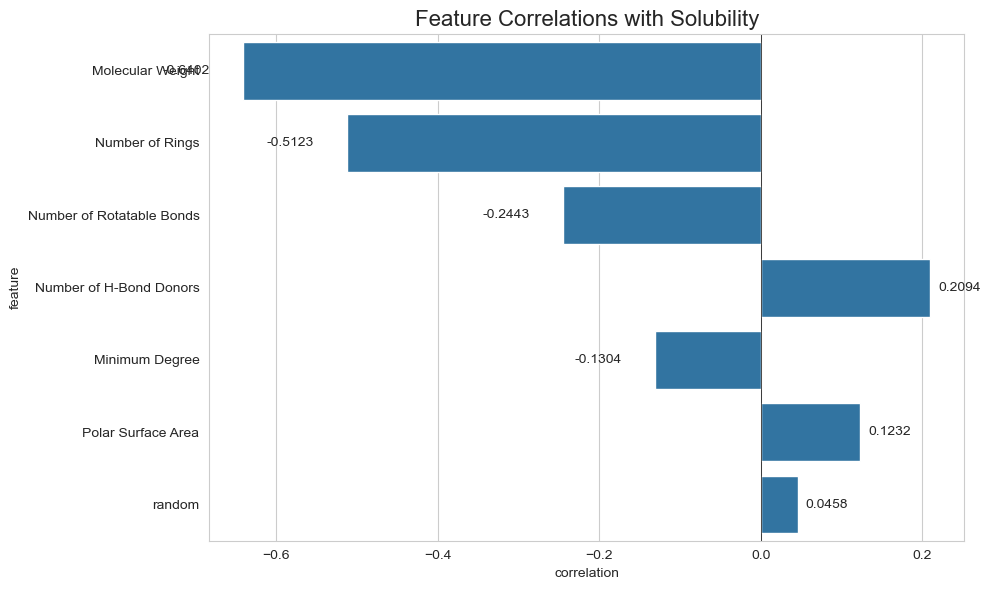


Training Random Forest model...
R^2 Training Score: 0.9749
OOB Score: 0.8179
R^2 Validation Score: 0.8225

Calculating default Scikit-learn feature importances...
Features ranked by default importance:
                     feature  feature_importance
0           Molecular Weight            0.559696
1         Polar Surface Area            0.241409
2            Number of Rings            0.063387
3  Number of Rotatable Bonds            0.053595
4                     random            0.043261
5    Number of H-Bond Donors            0.034976
6             Minimum Degree            0.003676


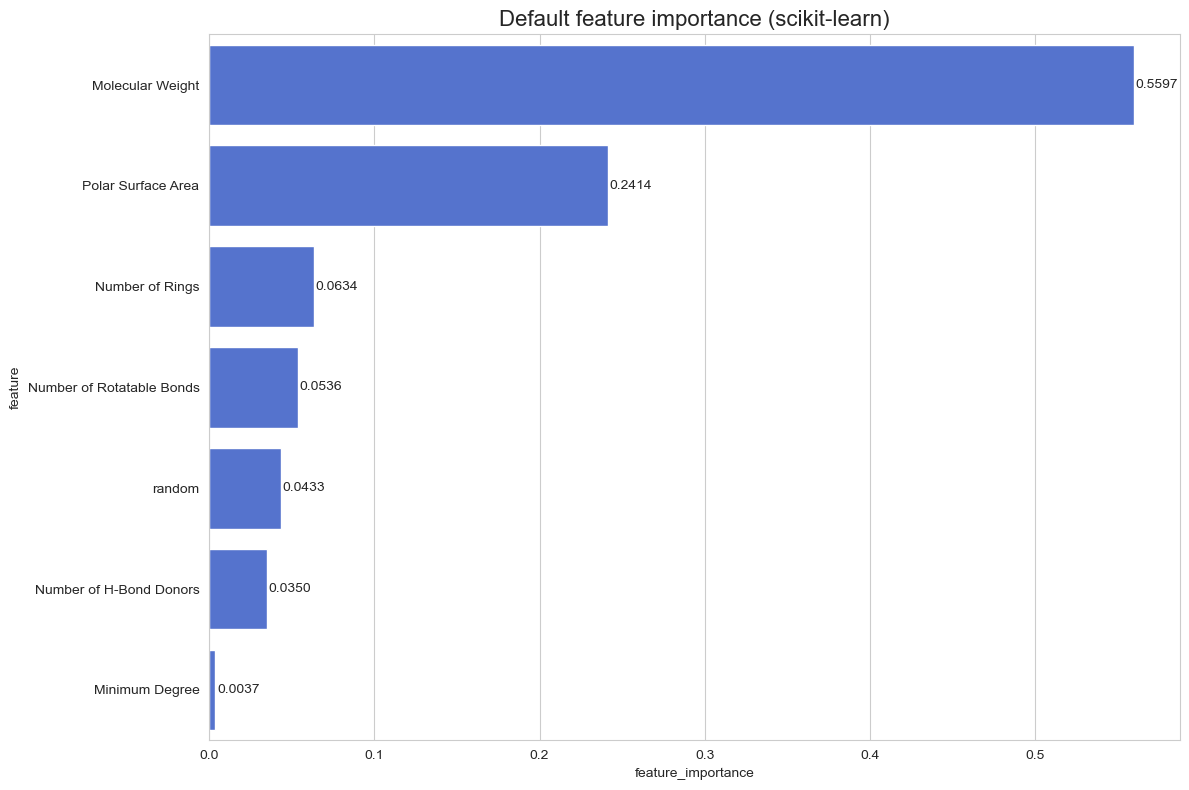


Random feature in default importance:
Rank: 5 out of 7 features
Top percentile: 28.57%
Importance value: 0.043261

Calculating permutation feature importance...
Features ranked by permutation importance:
                     feature  feature_importance
0           Molecular Weight            1.289065
1         Polar Surface Area            0.667231
2            Number of Rings            0.156820
3  Number of Rotatable Bonds            0.103136
4    Number of H-Bond Donors            0.061119
5                     random            0.045308
6             Minimum Degree            0.005504


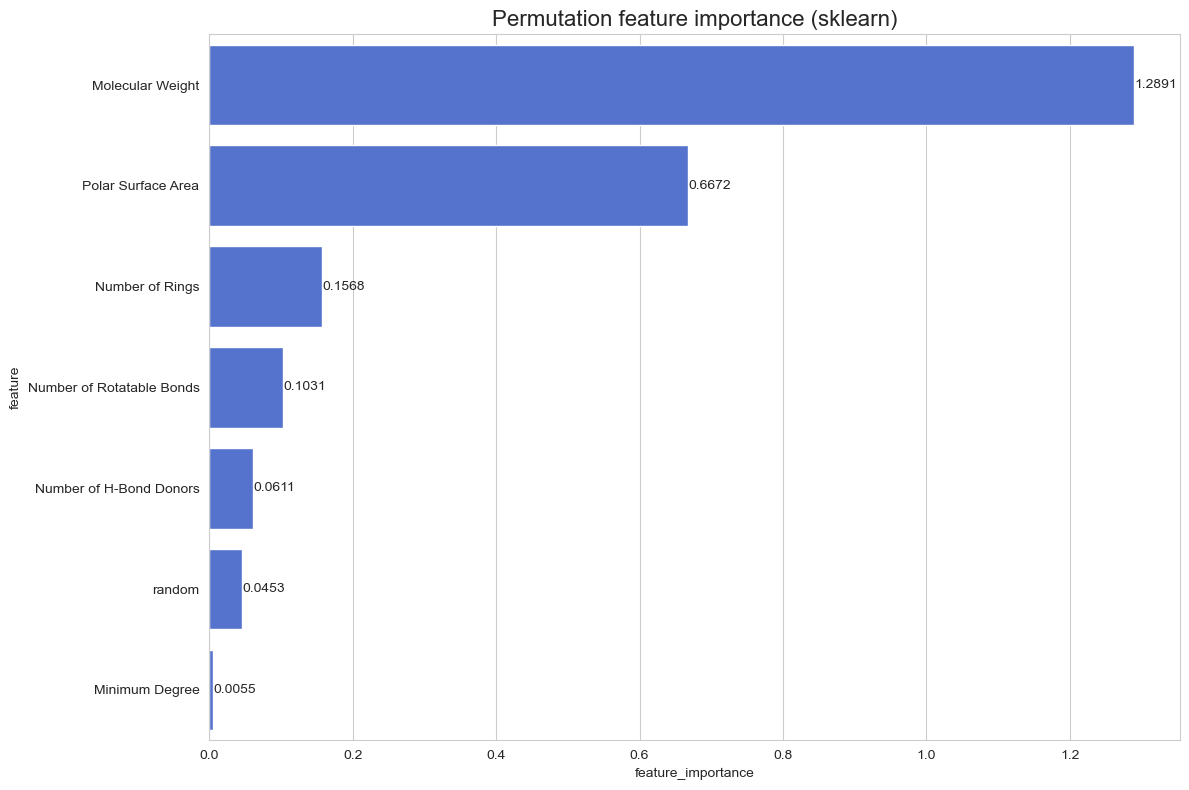


Random feature in permutation importance:
Rank: 6 out of 7 features
Top percentile: 14.29%
Importance value: 0.045308

Calculating drop-column feature importance...
Features ranked by drop-column importance:
                     feature  feature_importance
0           Molecular Weight            0.018230
1         Polar Surface Area            0.016599
2  Number of Rotatable Bonds            0.006008
3            Number of Rings            0.005493
4                     random            0.001783
5    Number of H-Bond Donors            0.001529
6             Minimum Degree            0.000106


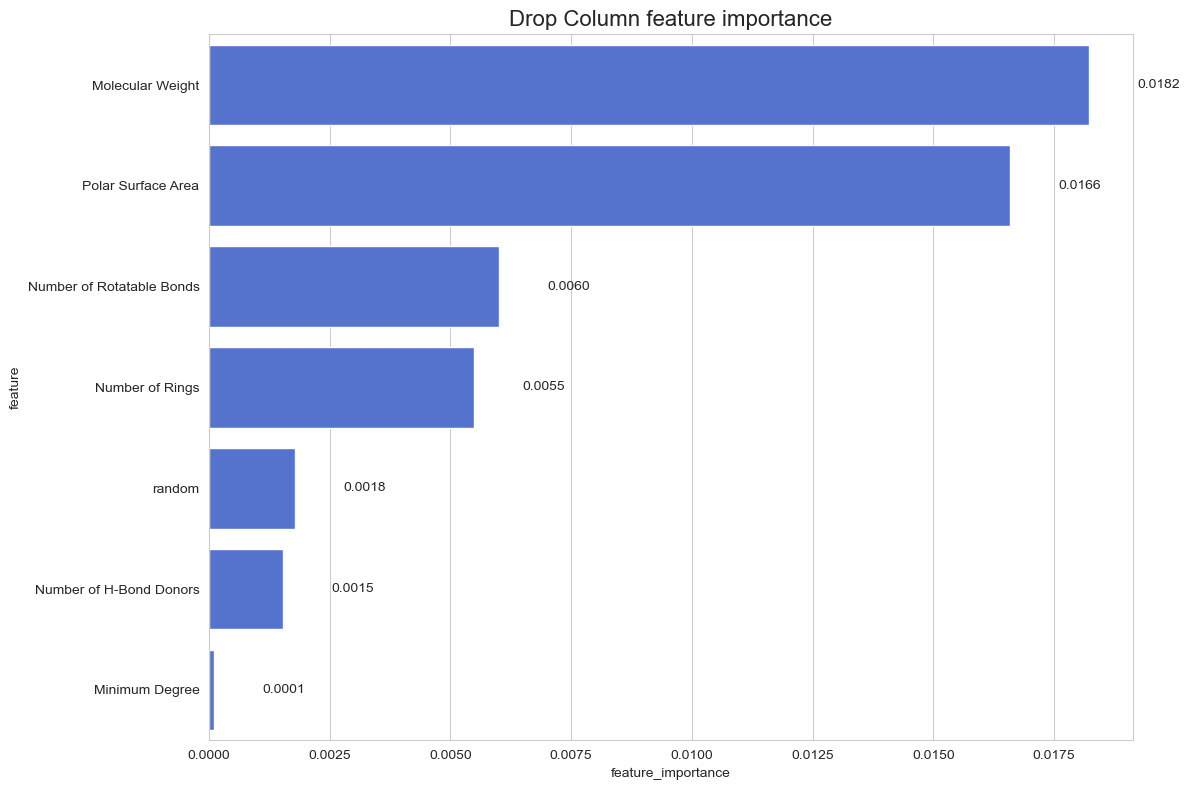


Random feature in drop-column importance:
Rank: 5 out of 7 features
Top percentile: 28.57%
Importance value: 0.001783

Calculating LIME for observation-level feature importance...
Index with smallest error: 236
Index with largest error: 181

LIME explanation for the instance with smallest error:
120.30 < Molecular Weight <= 182.20: 0.6860
26.30 < Polar Surface Area <= 55.52: 0.6041
Number of H-Bond Donors > 1.00: 0.3499
Number of Rotatable Bonds <= 0.00: 0.3334
random > 0.75: 0.0994
0.00 < Number of Rings <= 1.00: 0.0699
Minimum Degree <= 1.00: -0.0118

LIME explanation for the instance with largest error:
Polar Surface Area <= 0.00: -1.9097
120.30 < Molecular Weight <= 182.20: 0.6950
Number of Rotatable Bonds > 3.00: -0.5731
Number of H-Bond Donors <= 0.00: -0.1165
random > 0.75: 0.0883
0.00 < Number of Rings <= 1.00: 0.0583
Minimum Degree <= 1.00: 0.0439


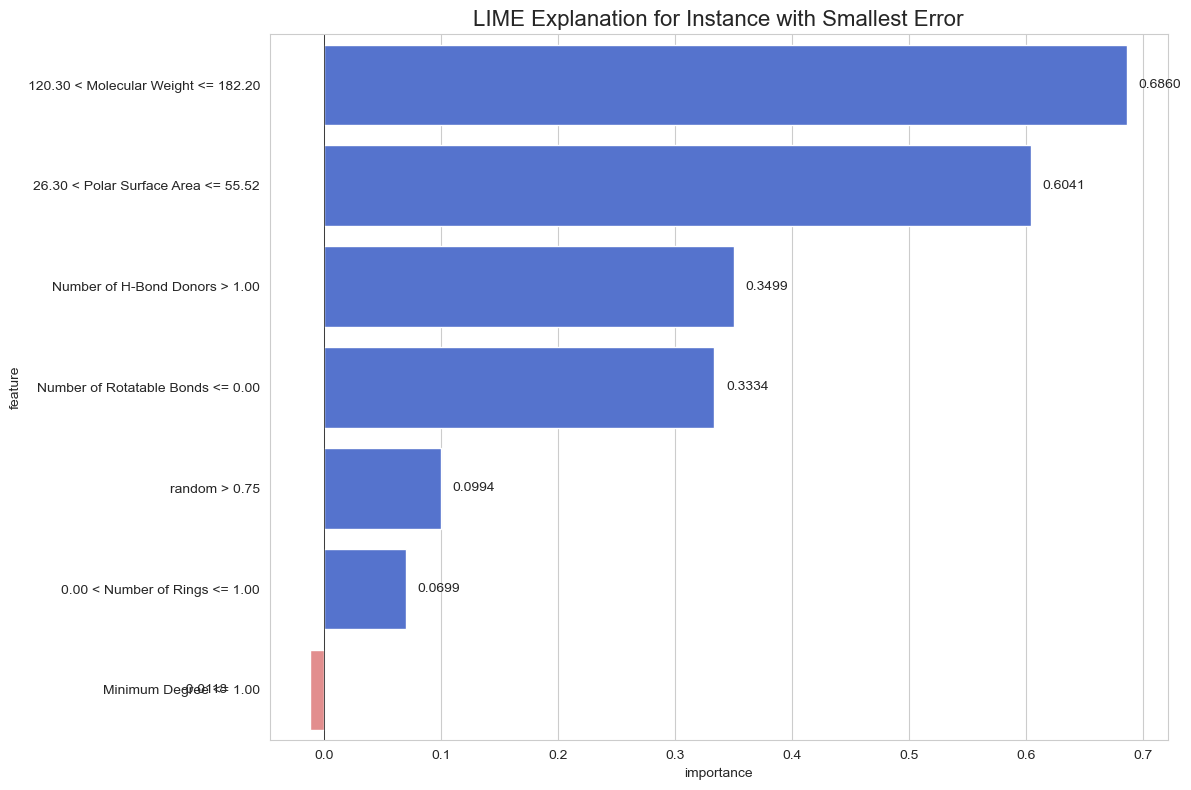

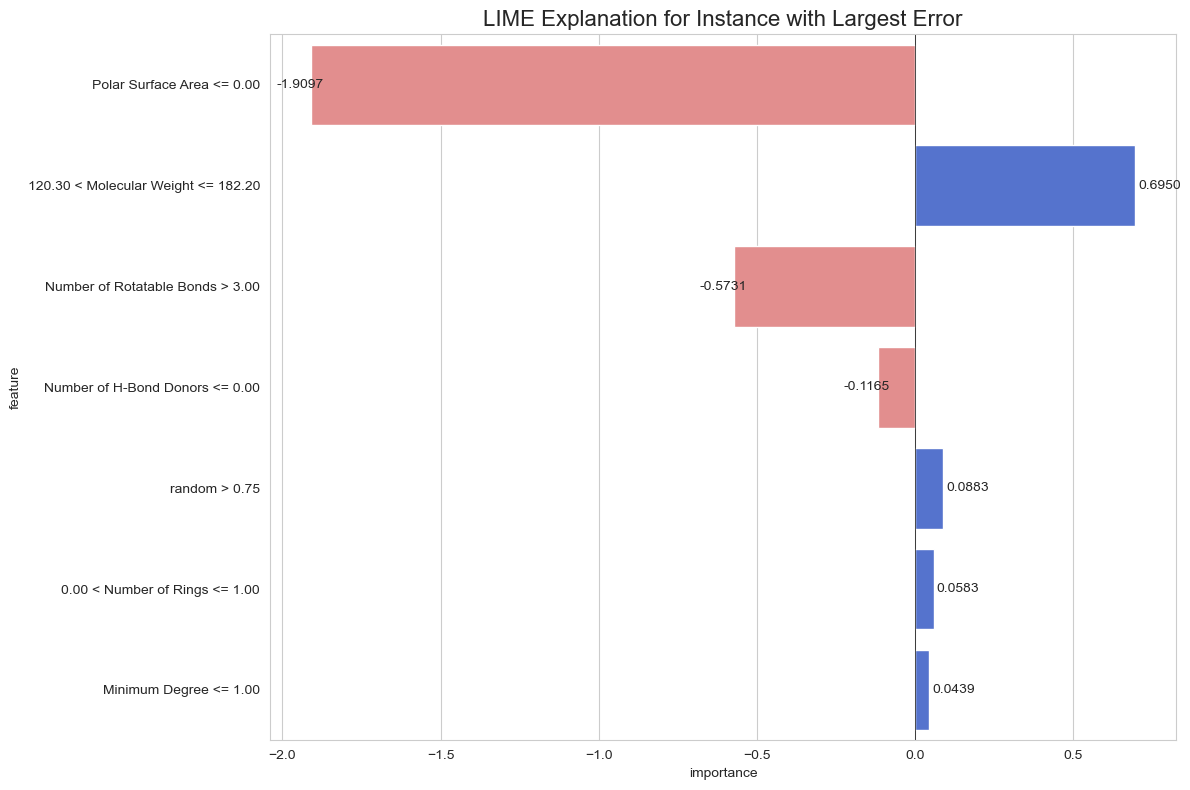


Checking for TreeInterpreter...

TreeInterpreter for Row 236
Prediction: -1.9392, Actual Value: -2.2730
Bias (training set mean): -3.0470
Feature contributions:
Molecular Weight: 0.9511
Polar Surface Area: 0.2508
Number of H-Bond Donors: -0.0912
random: -0.0486
Number of Rotatable Bonds: 0.0474
Minimum Degree: -0.0027
Number of Rings: 0.0008


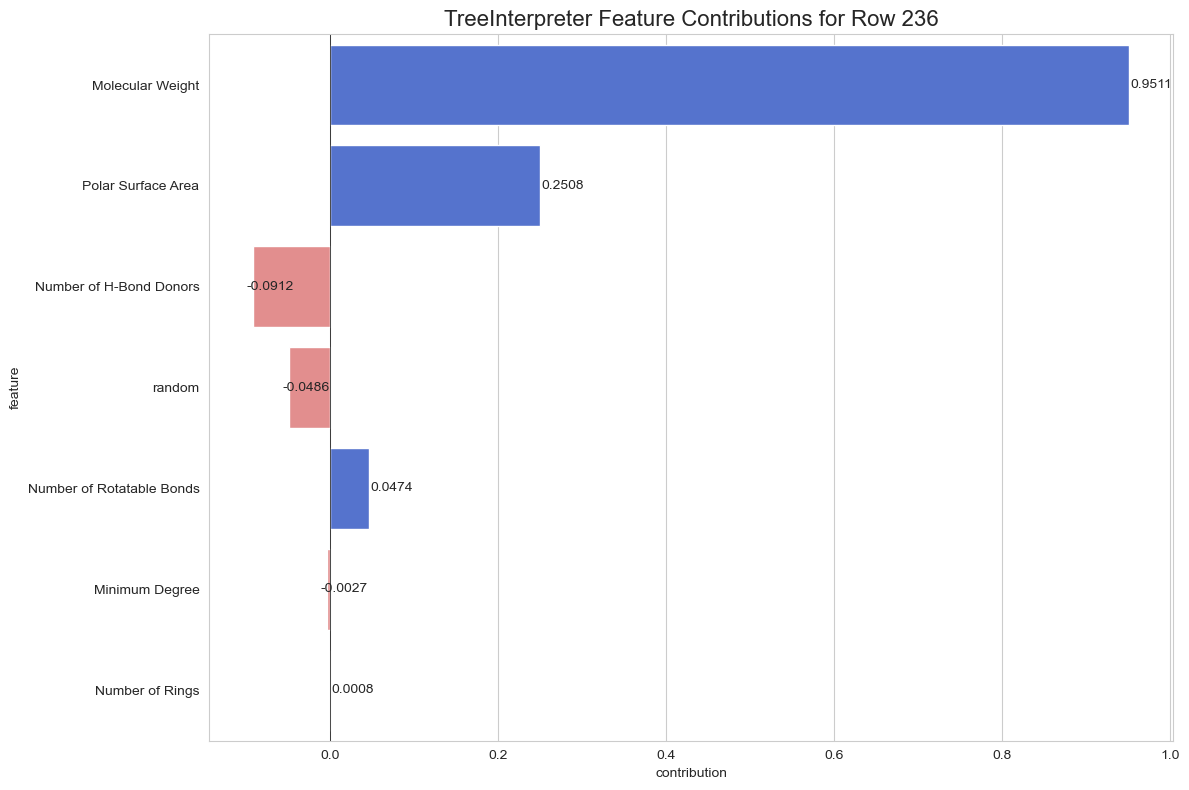


TreeInterpreter for Row 181
Prediction: -5.0046, Actual Value: -5.2100
Bias (training set mean): -3.0470
Feature contributions:
Number of Rotatable Bonds: -1.3103
Polar Surface Area: -1.1194
Molecular Weight: 0.5804
random: -0.0810
Number of Rings: -0.0261
Number of H-Bond Donors: -0.0014
Minimum Degree: 0.0001


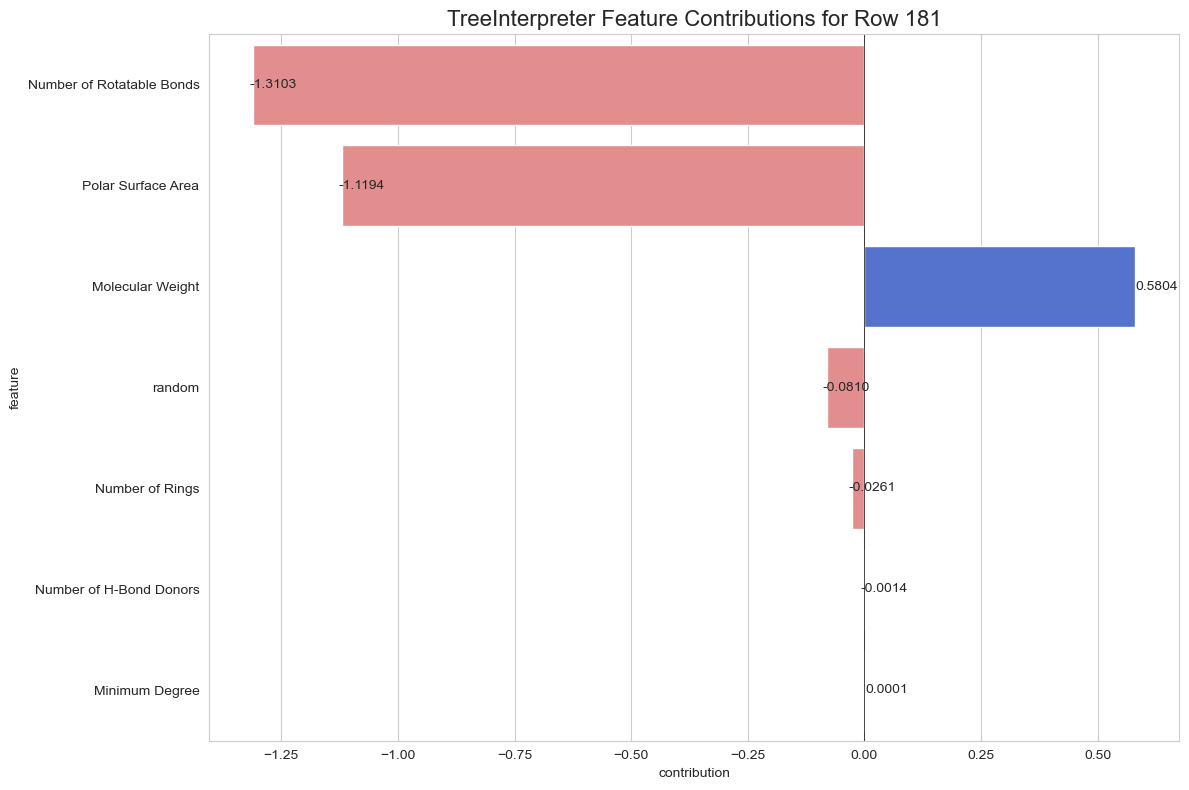


Comparing importance methods:
                     Feature   Default  Permutation  Drop-Column
0           Molecular Weight  0.559696     1.289065     0.018230
1         Polar Surface Area  0.241409     0.667231     0.016599
2            Number of Rings  0.063387     0.156820     0.005493
3  Number of Rotatable Bonds  0.053595     0.103136     0.006008
4                     random  0.043261     0.045308     0.001783
5    Number of H-Bond Donors  0.034976     0.061119     0.001529
6             Minimum Degree  0.003676     0.005504     0.000106


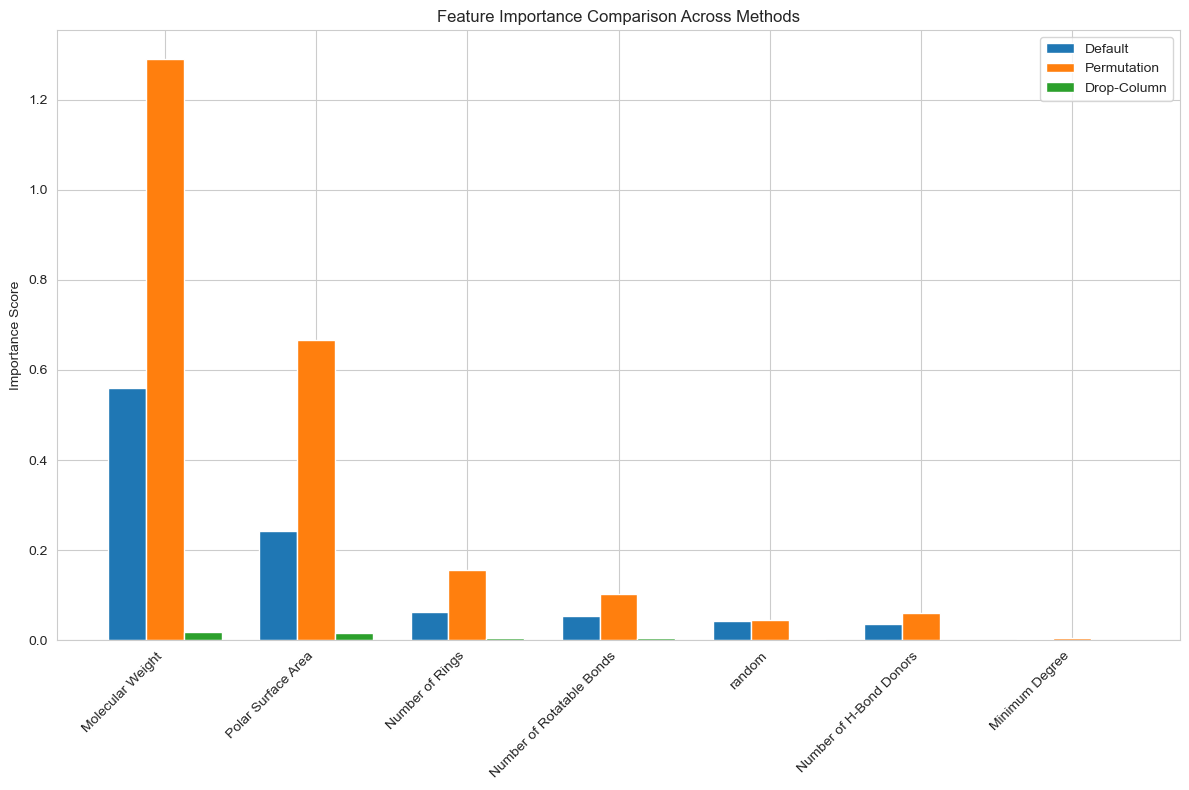


Feature Importance Analysis Complete


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import lime
import lime.lime_tabular
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set up visualization parameters
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Improved visualization function that shows all features (since we now have fewer, interpretable ones)
def var_imp_plot(imp_df, title, figsize=(12, 8)):
    """
    Plot feature importances as a horizontal bar chart
    """
    plt.figure(figsize=figsize)
    ax = sns.barplot(x='feature_importance', y='feature', data=imp_df, orient='h', color='royalblue')
    
    # Add value labels to the bars
    for i, v in enumerate(imp_df['feature_importance']):
        ax.text(max(v + 0.001, 0.001), i, f'{v:.4f}', va='center')
    
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Function to analyze random feature position
def analyze_random_feature(imp_df):
    """
    Analyze where the random feature ranks in importance
    """
    # Find position of random feature
    random_row = imp_df[imp_df['feature'] == 'random']
    if len(random_row) == 0:
        return "Random feature not found in results"
    
    random_rank = random_row.index[0] + 1  # +1 for human-readable ranking (1-based)
    random_importance = random_row['feature_importance'].values[0]
    total_features = len(imp_df)
    
    return {
        "rank": random_rank,
        "total_features": total_features, 
        "percentile": 100 * (total_features - random_rank) / total_features,
        "importance_value": random_importance
    }

# Helper function for feature importance dataframe
def imp_df(column_names, importances):
    """Create a dataframe of feature importances"""
    df = pd.DataFrame({
        'feature': column_names,
        'feature_importance': importances
    }).sort_values('feature_importance', ascending=False).reset_index(drop=True)
    return df

# Function for LIME visualization
def plot_lime_explanation(exp_list, title):
    """
    Create a horizontal bar chart from LIME explanation list
    """
    # Convert the explanation list to a DataFrame
    features = [item[0] for item in exp_list]
    importances = [item[1] for item in exp_list]
    
    # Create DataFrame and sort
    df = pd.DataFrame({
        'feature': features,
        'importance': importances
    })
    df = df.sort_values('importance', key=abs, ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 8))
    colors = ['royalblue' if x > 0 else 'lightcoral' for x in df['importance']]
    ax = sns.barplot(x='importance', y='feature', data=df, palette=colors)
    
    # Add value labels
    for i, v in enumerate(df['importance']):
        ax.text(v + 0.01 if v >= 0 else v - 0.11, i, f'{v:.4f}', va='center')
    
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Load and prepare dataset
print("Loading ESOL dataset from CSV file...")
df = pd.read_csv('./delaney-processed.csv')

# Display basic information about the dataset
print(f"Total number of compounds: {len(df)}")
print("Feature columns:")
feature_cols = ['Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 
                'Number of Rotatable Bonds', 'Polar Surface Area', 'Minimum Degree']

for col in feature_cols:
    print(f"- {col}: {df[col].min()} to {df[col].max()}")

# Separate features and target
X = df[feature_cols].copy()
y = df['measured log solubility in mols per litre']

# Add a random feature (as in the Boston dataset example)
np.random.seed(42)
X['random'] = np.random.random(size=len(X))

# Split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train set: {X_train.shape}, Validation set: {X_valid.shape}")
print(f"Target variable: measured log solubility in mols per litre")

# Check correlation between features and target
correlations = {col: np.corrcoef(X[col], y)[0, 1] for col in X.columns}
correlations_df = pd.DataFrame({
    'feature': list(correlations.keys()),
    'correlation': list(correlations.values())
}).sort_values('correlation', key=abs, ascending=False)

print("\nFeature correlations with target (solubility):")
print(correlations_df)

# Visualize correlations
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='correlation', y='feature', data=correlations_df, orient='h')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.title("Feature Correlations with Solubility", fontsize=16)
for i, v in enumerate(correlations_df['correlation']):
    ax.text(v + 0.01 if v >= 0 else v - 0.1, i, f'{v:.4f}', va='center')
plt.tight_layout()
plt.show()

# 1. Train a Random Forest model
print("\nTraining Random Forest model...")
rf = RandomForestRegressor(
    n_estimators=100,
    n_jobs=-1,
    oob_score=True,
    bootstrap=True,
    random_state=42
)
rf.fit(X_train, y_train)

# Evaluate model performance
train_r2 = rf.score(X_train, y_train)
valid_r2 = rf.score(X_valid, y_valid)
oob_score = rf.oob_score_

print(f"R^2 Training Score: {train_r2:.4f}")
print(f"OOB Score: {oob_score:.4f}")
print(f"R^2 Validation Score: {valid_r2:.4f}")

# 2. Default Scikit-learn feature importance
print("\nCalculating default Scikit-learn feature importances...")
base_imp = imp_df(X_train.columns, rf.feature_importances_)
print("Features ranked by default importance:")
print(base_imp)

# Plot features
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

# Analyze random feature in default importance
default_random_analysis = analyze_random_feature(base_imp)
print("\nRandom feature in default importance:")
print(f"Rank: {default_random_analysis['rank']} out of {default_random_analysis['total_features']} features")
print(f"Top percentile: {default_random_analysis['percentile']:.2f}%")
print(f"Importance value: {default_random_analysis['importance_value']:.6f}")

# 3. Permutation feature importance (using sklearn's implementation)
print("\nCalculating permutation feature importance...")

# Using scikit-learn's permutation_importance
perm_result = permutation_importance(rf, X_train, y_train, 
                                     n_repeats=10, random_state=42)
perm_imp_sklearn = imp_df(X_train.columns, perm_result.importances_mean)
print("Features ranked by permutation importance:")
print(perm_imp_sklearn)

# Plot features
var_imp_plot(perm_imp_sklearn, 'Permutation feature importance (sklearn)')

# Analyze random feature in permutation importance
perm_random_analysis = analyze_random_feature(perm_imp_sklearn)
print("\nRandom feature in permutation importance:")
print(f"Rank: {perm_random_analysis['rank']} out of {perm_random_analysis['total_features']} features")
print(f"Top percentile: {perm_random_analysis['percentile']:.2f}%")
print(f"Importance value: {perm_random_analysis['importance_value']:.6f}")

# 4. Drop-column feature importance
print("\nCalculating drop-column feature importance...")

def drop_col_feat_imp(model, X_train, y_train, random_state=42):
    """Calculate feature importance by dropping columns one by one"""
    # Clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    model_clone.random_state = random_state
    
    # Train and score the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    importances = []

    # Iterate over all columns and calculate importance
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        X_drop = X_train.drop(col, axis=1)
        model_clone.fit(X_drop, y_train)
        drop_col_score = model_clone.score(X_drop, y_train)
        importances.append(benchmark_score - drop_col_score)

    return importances

drop_imp = drop_col_feat_imp(rf, X_train, y_train)
drop_imp_df = imp_df(X_train.columns, drop_imp)
print("Features ranked by drop-column importance:")
print(drop_imp_df)

# Plot features
var_imp_plot(drop_imp_df, 'Drop Column feature importance')

# Analyze random feature in drop-column importance
drop_random_analysis = analyze_random_feature(drop_imp_df)
print("\nRandom feature in drop-column importance:")
print(f"Rank: {drop_random_analysis['rank']} out of {drop_random_analysis['total_features']} features")
print(f"Top percentile: {drop_random_analysis['percentile']:.2f}%")
print(f"Importance value: {drop_random_analysis['importance_value']:.6f}")

# 5. LIME for observation-level feature importance
print("\nCalculating LIME for observation-level feature importance...")

# Find observations with smallest and largest prediction errors
y_pred_train = rf.predict(X_train)
pred_diff = pd.DataFrame({'difference': abs(y_train - y_pred_train)})
best_idx = pred_diff.sort_values('difference').head(1).index.values[0]
worst_idx = pred_diff.sort_values('difference', ascending=False).head(1).index.values[0]

print(f"Index with smallest error: {best_idx}")
print(f"Index with largest error: {worst_idx}")

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    mode='regression',
    feature_names=X_train.columns,
    discretize_continuous=True
)

# Explain a well-predicted instance
np.random.seed(42)
exp_best = explainer.explain_instance(X_train.iloc[best_idx].values, rf.predict, num_features=len(X_train.columns))
best_explanation = exp_best.as_list()
print("\nLIME explanation for the instance with smallest error:")
for feature, importance in best_explanation:
    print(f"{feature}: {importance:.4f}")

# Explain a poorly-predicted instance
np.random.seed(42)
exp_worst = explainer.explain_instance(X_train.iloc[worst_idx].values, rf.predict, num_features=len(X_train.columns))
worst_explanation = exp_worst.as_list()
print("\nLIME explanation for the instance with largest error:")
for feature, importance in worst_explanation:
    print(f"{feature}: {importance:.4f}")

# Visualize LIME explanations
plot_lime_explanation(best_explanation, 'LIME Explanation for Instance with Smallest Error')
plot_lime_explanation(worst_explanation, 'LIME Explanation for Instance with Largest Error')

# Try to run TreeInterpreter (optional)
print("\nChecking for TreeInterpreter...")

try:
    from treeinterpreter import treeinterpreter as ti
    
    # Explain the same instances with TreeInterpreter
    selected_rows = [best_idx, worst_idx]
    selected_df = X_train.iloc[selected_rows].values
    prediction, bias, contributions = ti.predict(rf, selected_df)
    
    for i, idx in enumerate(selected_rows):
        print(f"\nTreeInterpreter for Row {idx}")
        print(f"Prediction: {prediction[i][0]:.4f}, Actual Value: {y_train.iloc[idx]:.4f}")
        print(f"Bias (training set mean): {bias[i]:.4f}")
        print("Feature contributions:")
        
        # Get contributions
        contributions_with_features = list(zip(contributions[i], X_train.columns))
        sorted_contributions = sorted(contributions_with_features, key=lambda x: -abs(x[0]))
        
        # Create dataframe for visualization
        contrib_df = pd.DataFrame({
            'feature': [feat for _, feat in sorted_contributions],
            'contribution': [contrib for contrib, _ in sorted_contributions]
        })
        
        # Print contributions
        for c, feature in sorted_contributions:
            print(f"{feature}: {c:.4f}")
        
        # Plot contributions
        plt.figure(figsize=(12, 8))
        colors = ['royalblue' if x > 0 else 'lightcoral' for x in contrib_df['contribution']]
        ax = sns.barplot(x='contribution', y='feature', data=contrib_df, palette=colors)
        
        # Add value labels
        for j, v in enumerate(contrib_df['contribution']):
            ax.text(v + 0.001 if v >= 0 else v - 0.008, j, f'{v:.4f}', va='center')
        
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.title(f'TreeInterpreter Feature Contributions for Row {idx}', fontsize=16)
        plt.tight_layout()
        plt.show()
        
except ImportError:
    print("TreeInterpreter not available. To use it, install with: pip install treeinterpreter")

# Compare the three importance methods side by side
print("\nComparing importance methods:")
importance_comparison = pd.DataFrame({
    'Feature': base_imp['feature'],
    'Default': base_imp['feature_importance'],
    'Permutation': [perm_imp_sklearn[perm_imp_sklearn['feature'] == feat]['feature_importance'].values[0] 
                   for feat in base_imp['feature']],
    'Drop-Column': [drop_imp_df[drop_imp_df['feature'] == feat]['feature_importance'].values[0] 
                  for feat in base_imp['feature']]
})

print(importance_comparison)

# Create a grouped bar chart for method comparison
features = importance_comparison['Feature']
default = importance_comparison['Default']
permutation = importance_comparison['Permutation']
drop_column = importance_comparison['Drop-Column']

plt.figure(figsize=(12, 8))
x = np.arange(len(features))
width = 0.25

plt.bar(x - width, default, width, label='Default')
plt.bar(x, permutation, width, label='Permutation')
plt.bar(x + width, drop_column, width, label='Drop-Column')

plt.ylabel('Importance Score')
plt.title('Feature Importance Comparison Across Methods')
plt.xticks(x, features, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

print("\nFeature Importance Analysis Complete")